In [1]:
import matplotlib as mpl
from utils import plot
import matplotlib.pyplot as plt
import numpy as np
import _pickle as pkl
import scipy.stats as stats
import tensorflow as tf
import time
from utils import dataReader, get_session, integrated_gradients, softmax, gini
from model import Model

In [2]:
semantic_labels = ['T-shirt', 'Trouser', 'Pullover', 'Dress', 'Coat', 'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']

In [3]:
X, y = dataReader()

Instructions for updating:
Please use alternatives such as official/mnist/dataset.py from tensorflow/models.
Instructions for updating:
Please write your own downloading logic.
Instructions for updating:
Please use tf.data to implement this functionality.
Extracting data/fashion/train-images-idx3-ubyte.gz
Instructions for updating:
Please use tf.data to implement this functionality.
Extracting data/fashion/train-labels-idx1-ubyte.gz
Extracting data/fashion/t10k-images-idx3-ubyte.gz
Extracting data/fashion/t10k-labels-idx1-ubyte.gz
Instructions for updating:
Please use alternatives such as official/mnist/dataset.py from tensorflow/models.


Image ID: 500, Image Label : Pullover


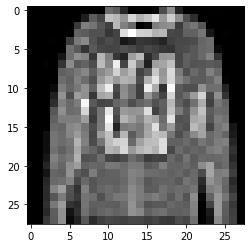

In [4]:
n = 500
original_label = y[n]
test_image = X[n]
plt.rcParams["figure.figsize"]=8,8
print("Image ID: {}, Image Label : {}".format(n, semantic_labels[y[n]]))
%matplotlib inline
plt.imshow(X[n,:,:,0], cmap='gray')

In [5]:
reference_image = np.zeros((28, 28, 1), dtype=np.float32)
num_steps = 100

# Natural Training

In [6]:
tf.reset_default_graph()
sess = get_session()
model = Model()
# restore models
model_dir = 'models/nat_trained'

saver = tf.train.Saver()
checkpoint = tf.train.latest_checkpoint(model_dir)
saver.restore(sess, checkpoint)






INFO:tensorflow:Restoring parameters from models/nat_trained/checkpoint-24900


In [7]:
nat_output = sess.run(model.output, feed_dict={model.input: [test_image]})
nat_pred = softmax(nat_output)

print('prediction: {}, confidence: {}'.format(semantic_labels[np.argmax(nat_pred)], np.max(nat_pred)))

prediction: Pullover, confidence: 0.9998032450675964


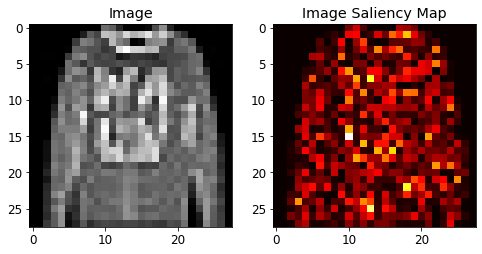

In [8]:
IG = integrated_gradients(sess, reference_image, test_image, original_label, model, gradient_func='output_input_gradient', steps=num_steps)

mpl.rcParams["figure.figsize"]=8,8
plt.rc("text",usetex=False)
plt.rc("font",family="sans-serif",size=12)
saliency = np.sum(np.abs(IG),-1)
nat_saliency = 28*28*saliency/np.sum(saliency)
plt.subplot(1,2,1)
plt.title("Image")
image = X[n,:,:,0]
plt.imshow(image, cmap='gray')
plt.subplot(1,2,2)
plt.title("Image Saliency Map")
plt.imshow(nat_saliency, cmap="hot")

In [9]:
gini_v = gini(IG.flatten())
print('The Gini for IG is:', gini_v)

The Gini for IG is: 0.5777714085730514


# Adversarial Traininig

In [10]:
tf.reset_default_graph()
sess = get_session()
model = Model()
# restore models
model_dir = 'models/adv_trained'

saver = tf.train.Saver()
checkpoint = tf.train.latest_checkpoint(model_dir)
saver.restore(sess, checkpoint)

INFO:tensorflow:Restoring parameters from models/adv_trained/checkpoint-99900


In [11]:
nat_output = sess.run(model.output, feed_dict={model.input: [test_image]})
nat_pred = softmax(nat_output)

print('prediction: {}, confidence: {}'.format(semantic_labels[np.argmax(nat_pred)], np.max(nat_pred)))

prediction: Pullover, confidence: 0.6610631942749023


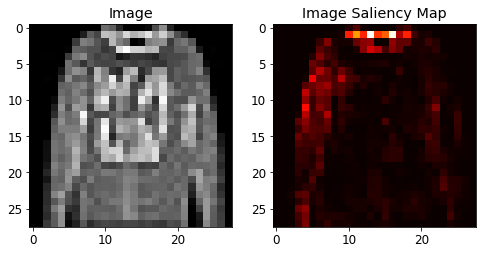

In [12]:
IG = integrated_gradients(sess, reference_image, test_image, original_label, model, gradient_func='output_input_gradient', steps=num_steps)

mpl.rcParams["figure.figsize"]=8,8
plt.rc("text",usetex=False)
plt.rc("font",family="sans-serif",size=12)
saliency = np.sum(np.abs(IG),-1)
adv_saliency = 28*28*saliency/np.sum(saliency)
plt.subplot(1,2,1)
plt.title("Image")
image = X[n,:,:,0]
plt.imshow(image, cmap='gray')
plt.subplot(1,2,2)
plt.title("Image Saliency Map")
plt.imshow(adv_saliency, cmap="hot")

In [13]:
gini_v = gini(IG.flatten())
print('The Gini for IG is:', gini_v)

The Gini for IG is: 0.7273487098386412


# L1 Norm Regularization 

In [14]:
tf.reset_default_graph()
sess = get_session()
model = Model()
# restore models
model_dir = 'models/nat_trained_with_l1_reg'

saver = tf.train.Saver()
checkpoint = tf.train.latest_checkpoint(model_dir)
saver.restore(sess, checkpoint)

INFO:tensorflow:Restoring parameters from models/nat_trained_with_l1_reg/checkpoint-24900


In [15]:
nat_output = sess.run(model.output, feed_dict={model.input: [test_image]})
nat_pred = softmax(nat_output)

print('prediction: {}, confidence: {}'.format(semantic_labels[np.argmax(nat_pred)], np.max(nat_pred)))

prediction: Pullover, confidence: 0.9173622131347656


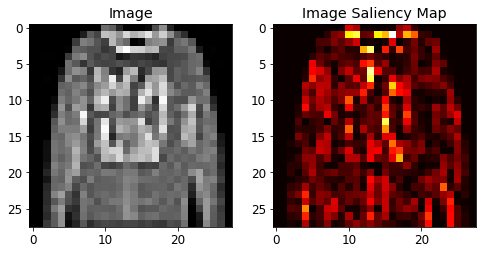

In [16]:
IG = integrated_gradients(sess, reference_image, test_image, original_label, model, gradient_func='output_input_gradient', steps=num_steps)

mpl.rcParams["figure.figsize"]=8,8
plt.rc("text",usetex=False)
plt.rc("font",family="sans-serif",size=12)
saliency = np.sum(np.abs(IG),-1)
l1_saliency = 28*28*saliency/np.sum(saliency)
plt.subplot(1,2,1)
plt.title("Image")
image = X[n,:,:,0]
plt.imshow(image, cmap='gray')
plt.subplot(1,2,2)
plt.title("Image Saliency Map")
plt.imshow(l1_saliency, cmap="hot")

In [17]:
gini_v = gini(IG.flatten())
print('The Gini for IG is:', gini_v)

The Gini for IG is: 0.5939087504230394
